# SDSS Image Classification


## Data

This analysis will be making use of image "chips," fragments of images containing only the relevant object of interest. Due to the variable size of these objects (e.g. objects closer to the Earth appear bigger), each image is clipped using a 2-dimensional Gaussian, clipped at $3 \sigma$. This will *usually* prevent other objects from appearing in the image chip, however some objects are so closely spaced together (or sparsely distrubted) that there may be evidence of other objects in some of the image chips.

In [1]:
# install things we might need 
!pip install "photutils[all]"
!pip install astropy
!pip install --pre astroquery
!pip install -q -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 855.2/855.2 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 23.6 MB/s eta 0:00:00
  Created wheel for asdf-wcs-schemas: filename=asdf_wcs_schemas-0.1.1-py3-none-any.whl size=26602 sha256=c38a3d6ff548a74

In [13]:

from pathlib import Path
import pickle


from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize
import pandas as pd
import numpy as np
from keras import models
import keras_tuner as kt

np.random.seed(42)
tf.random.set_seed(42)

# plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# stats stuff
from astropy.stats import sigma_clip
import photutils
from astroquery.sdss import SDSS




In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# data_dir = Path("/content/drive/MyDrive/MIDS/207/SDSS-Classification/data/64x64_ugriz")
data_dir = Path("/content/drive/MyDrive/MIDS/207/SDSS-Classification/data/")
img_dir = data_dir / "64x64_ugriz"
# img_dir = data_dir / "64x64_riz"
# img_dir = data_dir / "128x128_ugriz"


In [5]:
# # load in the image data (not needed for training!)

# print(img_dir.exists())
# if Path(img_dir / "imgs.pkl").exists():
#     print(f"Found pickled images, loading from pickle...")
#     with open(img_dir / "imgs.pkl", "rb") as f:
#         imgs = pickle.load(f)

# else:
#   print(f"Cant find imgs. Does the pickle exist at {data_dir}?")




In [6]:
# import matplotlib.pyplot as plt
# nrows = 2
# ncols = 4

# n_bands = imgs.shape[3]
# rand_idxs = np.random.randint(0, len(imgs), 8)
# rand_band = np.random.randint(0, n_bands, 8)
# plot_imgs = imgs[rand_idxs]

# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

# for i in range(nrows):
#   for j in range(ncols):
    
#     plot_idx = i*ncols + j
#     band_idx = rand_band[i*ncols + j]
#     ax[i, j].imshow(plot_imgs[plot_idx,:,:, band_idx], cmap='gray')
    


## Data Processing

Due to the asymetrical nature of the data (reference the label distributions in the EDA.ipynb), we will be randomly throwing out some of our images in order to train our models on a more evenly distributed data set. 

We won't do that here (since we already did it in `SDSS Image Classification - Preprocessing.ipynb`) 

We just load the pickled objects.


In [8]:
with open(img_dir / "X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open(img_dir / "y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open(img_dir / "X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

with open(img_dir / "y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

with open(img_dir / "X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
    
with open(img_dir / "y_test.pkl", "rb") as f:
    y_test = pickle.load(f)


n_bands = X_train.shape[3]


## Models

I will be taking two approaches to this problem: One using the raw chip data (e.g. no transformations) and another scaling the chip data to have the same dimensions. This in turn will require using differing models, Fully Connected Network (FCN) and a Convolutional Neural Network (CNN).

### Fully Connected Network


In [8]:
# FCN implementation here

### Convolutional Neural Network

In [30]:
cnn_model = models.Sequential()

# add first convolution layer to the model
cnn_model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
cnn_model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add first convolution layer to the model
cnn_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_2',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
cnn_model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_2'))




# add a fully connected layer (need to flatten the output of the previous layers first)
cnn_model.add(tf.keras.layers.Flatten()) 
cnn_model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
cnn_model.add(tf.keras.layers.Dropout(
    rate=0.5))



cnn_model.add(tf.keras.layers.Dense(
    units=3,
    name='fc_2',
    activation=None))



tf.random.set_seed(1)
cnn_model.build(input_shape=(None, 64, 64, 5))
cnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        4032      
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              16778240  
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [31]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [32]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = cnn_model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val)
)

Epoch 1/5
1077/1077 [==============================] - 8s 6ms/step - loss: 0.6529 - accuracy: 0.7395 - val_loss: 0.5533 - val_accuracy: 0.7829
Epoch 2/5
1077/1077 [==============================] - 6s 5ms/step - loss: 0.5581 - accuracy: 0.7813 - val_loss: 0.5222 - val_accuracy: 0.7996
Epoch 3/5
1077/1077 [==============================] - 6s 5ms/step - loss: 0.5310 - accuracy: 0.7935 - val_loss: 0.5231 - val_accuracy: 0.7958
Epoch 4/5
1077/1077 [==============================] - 6s 5ms/step - loss: 0.5101 - accuracy: 0.8003 - val_loss: 0.5179 - val_accuracy: 0.8036
Epoch 5/5
1077/1077 [==============================] - 6s 5ms/step - loss: 0.4834 - accuracy: 0.8102 - val_loss: 0.5249 - val_accuracy: 0.8043


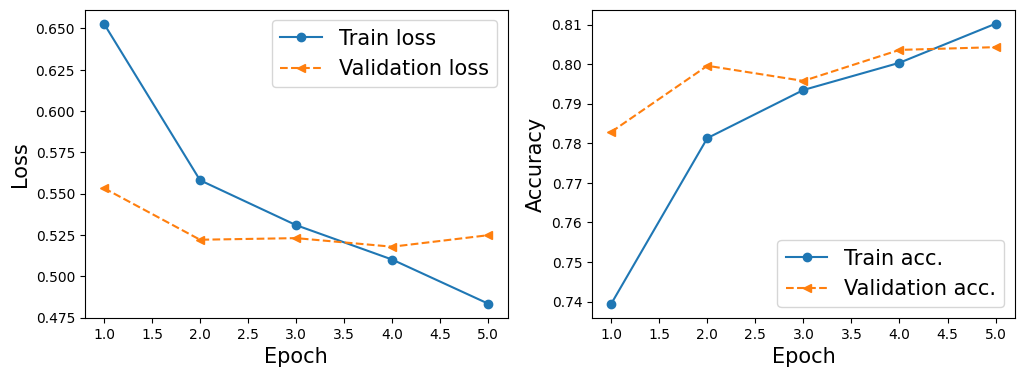

In [33]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [34]:
cnn_model.evaluate(X_test, y_test)

180/180 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.8038


[0.5093523263931274, 0.8037952780723572]

In [35]:
# lets pick a subset of the train datasets to iterate faster and find good hyperparameters

train_subset_size = int(0.1 * len(X_train))
val_subset_size = int(0.1 * len(X_val))

train_subset_idxs = np.random.choice(
    np.arange(0, len(X_train), 1),
    size = train_subset_size,
    replace=False
)


val_subset_idxs = np.random.choice(
    np.arange(0, len(X_val), 1),
    size = val_subset_size,
    replace=False
)



X_train_subset = tf.gather(X_train, train_subset_idxs)
y_train_subset = tf.gather(y_train, train_subset_idxs)

X_val_subset = tf.gather(X_val, val_subset_idxs)
y_val_subset = tf.gather(y_val, val_subset_idxs)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))

34458 34458
5743 5743


In [38]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()


    # tune the number of filters to use in the first conv layer
    hp_filters = hp.Int('filters', min_value=32, max_value = 128, step=8)
    hp_n_layers = hp.Int("layers", 2, 10,)
    # hp_kernel_size = hp.Int('filters_size', min_value=2, max_value=10, step=1)
    # hp_strides_size = hp.Int("strides_size", min_value=1, max_value=5, step=1)
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])


    for i in range(hp_n_layers):
      model.add(
          tf.keras.layers.Conv2D(
              filters=hp_filters,
              kernel_size=(5, 5),
              strides=(1, 1),
              padding='same',
              data_format="channels_last",
              name=f"conv_{i}",
              activation='relu'
          )
      )

      model.add(
          tf.keras.layers.MaxPool2D(
              pool_size = (2,2),
              name=f"pool_{i}"
          )
      )





    # # add first convolution layer to the model
    # model.add(tf.keras.layers.Conv2D(
    #     filters=hp_filters,
    #     kernel_size=(5, 5),
    #     strides=(1, 1),
    #     padding='same',
    #     data_format='channels_last',
    #     name='conv_1',
    #     activation='relu'))


    # # add a max pooling layer with pool size (2,2) and strides of 2
    # # (this will reduce the spatial dimensions by half)
    # model.add(tf.keras.layers.MaxPool2D(
    #     pool_size=(2, 2),
    #     name='pool_1'))


    # # add second convolutional layer
    # model.add(tf.keras.layers.Conv2D(
    #     filters=16,
    #     kernel_size=(5, 5),
    #     strides=(1, 1),
    #     padding='same',
    #     name='conv_2',
    #     activation='relu'))

    # # add second max pooling layer with pool size (2,2) and strides of 2
    # # (this will further reduce the spatial dimensions by half)
    # model.add(tf.keras.layers.MaxPool2D(
    #     pool_size=(2, 2), name='pool_2')
    # )





    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=2048,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    model.add(tf.keras.layers.Dense(
        units=3,
        name='fc_2',
        activation=None))






    model.build(input_shape=(None, 64, 64, n_bands))
    # model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics=['accuracy']) 

    return model

  def fit(self, hp, model, *args, **kwargs):
    # hp_batch_size = hp.Int('batch_size', min_value=64, max_value=1024, step=64)
    return model.fit(
        *args,
        **kwargs
    )



In [39]:

hp = kt.HyperParameters()

tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name = 'sdss_cnn',
)






# model = create_model()
# tf.keras.KerasClassifier()
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
#               metrics=['accuracy']) 


In [40]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [41]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 8, 'sampling': 'linear'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


In [42]:
tuner.search(X_train_subset, y_train_subset,
             validation_data=(X_val_subset, y_val_subset), callbacks=[stop_early])




Trial 23 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.7909407615661621
Total elapsed time: 00h 02m 12s


In [43]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'filters': 40,
 'layers': 3,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [44]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_subset, y_train_subset, epochs=50, validation_data=(X_val_subset, y_val_subset))


# find the best # of epochs to use
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
108/108 [==============================] - 3s 8ms/step - loss: 0.8494 - accuracy: 0.6046 - val_loss: 0.6696 - val_accuracy: 0.7125
Epoch 2/50
108/108 [==============================] - 1s 6ms/step - loss: 0.7036 - accuracy: 0.7193 - val_loss: 0.6353 - val_accuracy: 0.7561
Epoch 3/50
108/108 [==============================] - 1s 6ms/step - loss: 0.6409 - accuracy: 0.7451 - val_loss: 0.5971 - val_accuracy: 0.7735
Epoch 4/50
108/108 [==============================] - 1s 6ms/step - loss: 0.6058 - accuracy: 0.7608 - val_loss: 0.6152 - val_accuracy: 0.7805
Epoch 5/50
108/108 [==============================] - 1s 6ms/step - loss: 0.5718 - accuracy: 0.7745 - val_loss: 0.5748 - val_accuracy: 0.7805
Epoch 6/50
108/108 [==============================] - 1s 6ms/step - loss: 0.5525 - accuracy: 0.7742 - val_loss: 0.5838 - val_accuracy: 0.7822
Epoch 7/50
108/108 [==============================] - 1s 6ms/step - loss: 0.5322 - accuracy: 0.7904 - val_loss: 0.6029 - val_accuracy: 0.7997
Epoch 

In [45]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data = (X_val, y_val))


Epoch 1/7
1077/1077 [==============================] - 9s 7ms/step - loss: 0.6304 - accuracy: 0.7490 - val_loss: 0.5807 - val_accuracy: 0.7749
Epoch 2/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.5501 - accuracy: 0.7854 - val_loss: 0.5105 - val_accuracy: 0.8011
Epoch 3/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.5275 - accuracy: 0.7927 - val_loss: 0.5146 - val_accuracy: 0.8038
Epoch 4/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.5106 - accuracy: 0.7990 - val_loss: 0.4944 - val_accuracy: 0.8119
Epoch 5/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.4940 - accuracy: 0.8062 - val_loss: 0.4983 - val_accuracy: 0.8140
Epoch 6/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.4859 - accuracy: 0.8093 - val_loss: 0.5022 - val_accuracy: 0.8147
Epoch 7/7
1077/1077 [==============================] - 6s 6ms/step - loss: 0.4699 - accuracy: 0.8153 - val_loss: 0.5122 - val_accuracy: 0.8065

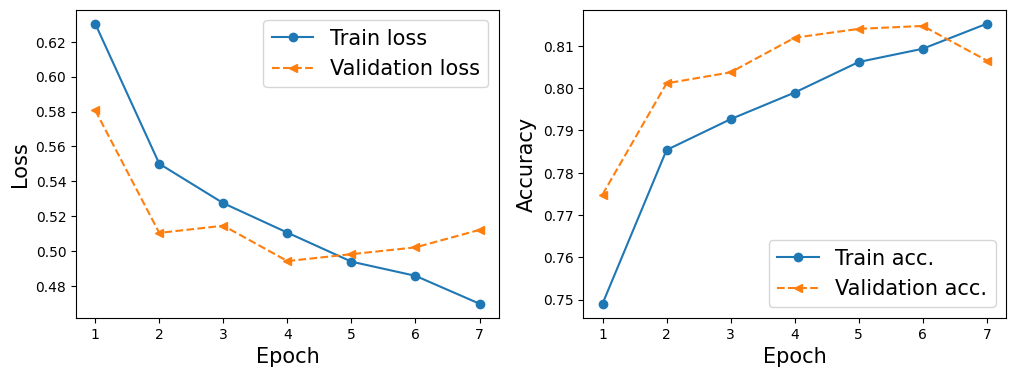

In [46]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show(   )

In [47]:
model.evaluate(X_test, y_test)

180/180 [==============================] - 1s 4ms/step - loss: 4.0285 - accuracy: 0.7474


[4.028452396392822, 0.7473886013031006]

## Applying to an entire image (for fun)

In [235]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.visualization import ZScaleInterval, SinhStretch, ImageNormalize


def get_img_plate(row):
    row = row.squeeze()
    bands = ['u', 'g', 'r', 'i', 'z']
    run_id = row['run_ID']
    rerun_id = row['rerun_ID']
    cam_col = row['cam_col']
    field_id = row['field_ID']

    ra = Angle(row['alpha'], u.deg)
    dec = Angle(row['delta'], u.deg)
    c = SkyCoord(ra, dec, frame='icrs')

    xids_table = SDSS.query_region(c)


    xids_table = SDSS.query_region(c) # this can return multiple items
    xids = xids_table.to_pandas()
    xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
    xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
    best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

    best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))
    img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]


    return img_data_buffer

In [236]:
df = pd.read_csv(data_dir / "star_classification.csv")


In [281]:
def scale_img(img_data):

  # scale the image so its viewable
  interval = ZScaleInterval(max_iterations=10)
  vmin, vmax = interval.get_limits(img_data)
  norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch(), clip=True)
  img_data = norm(img_data)

  return img_data



# lets try the above model on a full frame and see what it classifies

rand_idx = np.random.randint(0, len(df), 1)

# get a full frame
img_data_buffer = get_img_plate(df.iloc[rand_idx])
img_data_buffer = [scale_img(img_data[0][0].data) for img_data in img_data_buffer]


# pick a band
rand_band_idx = np.random.randint(0, n_bands, 1)[0]

img_data = img_data_buffer[rand_band_idx]







In [282]:
print([img_data.min() for img_data in img_data_buffer])
print([img_data.max() for img_data in img_data_buffer])

[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]


[81655]
3


(-0.5, 2047.5, 1488.5, -0.5)

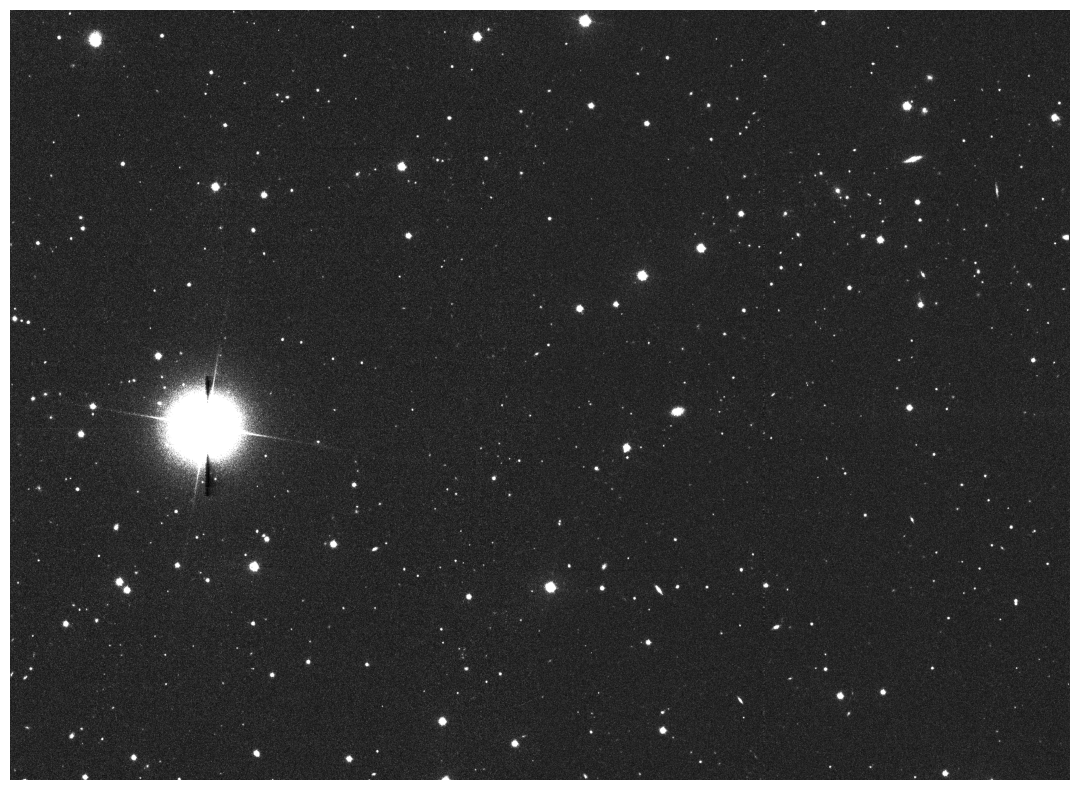

In [283]:
print(rand_idx)
print(rand_band_idx)
plt.figure(figsize=(16,10))
plt.imshow(img_data, cmap="gray")
plt.axis("off")

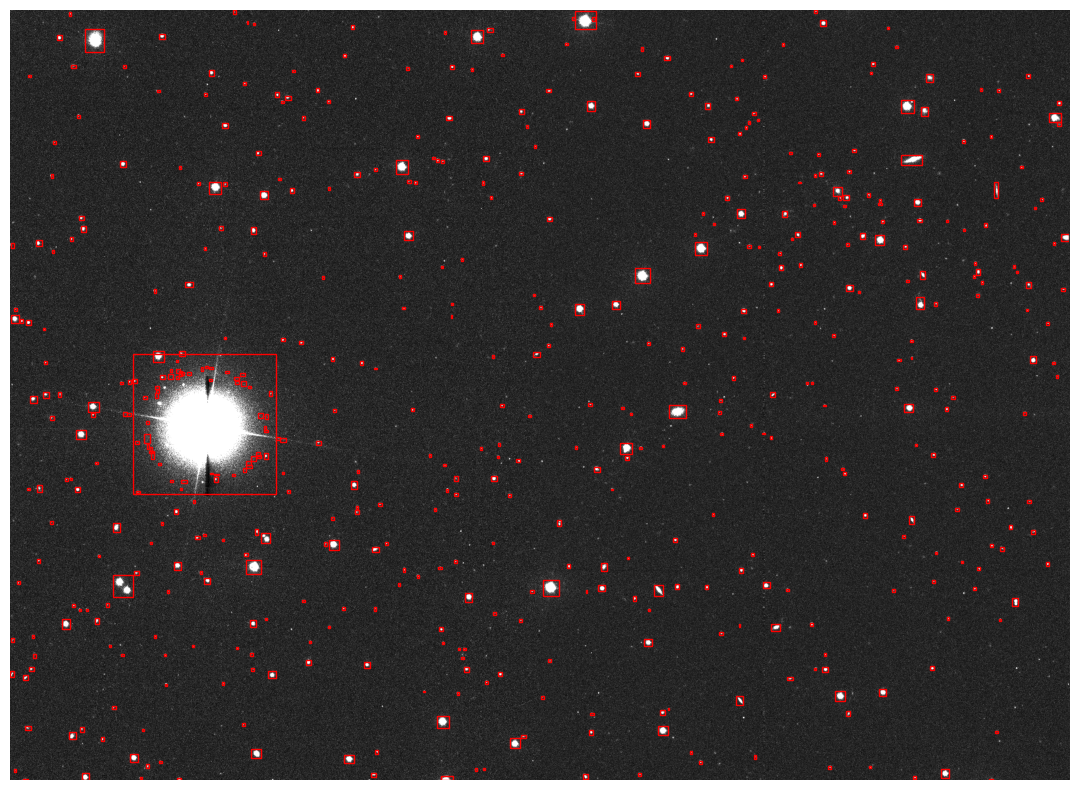

In [284]:
from photutils.detection import find_peaks
from photutils.segmentation import detect_sources, detect_threshold, SourceFinder, SourceCatalog

# find some peaks
threshold = detect_threshold(img_data, nsigma=3)
source_map = detect_sources(img_data, npixels=10, threshold=threshold)

sources = SourceCatalog(data=img_data, segment_img=source_map)


# cutouts = sources.make_cutouts(shape=(100,100), mode='trim')
cutouts = sources.slices


from matplotlib import patches
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,10)
ax.imshow(img_data, cmap="gray")
ax.axis("off")

for bbox in sources.bbox:
  rect = patches.Rectangle(xy=(bbox.ixmin, bbox.iymin), width=(bbox.ixmax - bbox.ixmin), height=(bbox.iymax - bbox.iymin), edgecolor='red', fill=False)
  ax.add_patch(rect)

In [285]:
all_bands_img_data = np.ndarray(shape=(img_data.shape[0], img_data.shape[1], len(img_data_buffer)))
all_bands_sources = []

for idx, band_data in enumerate(img_data_buffer):
  band_img_data = band_data
  all_bands_img_data[:,:,idx] = band_img_data

  threshold = detect_threshold(band_img_data, nsigma=3)
  source_map = detect_sources(band_img_data, npixels=10, threshold=threshold)
  sources = SourceCatalog(data=band_img_data, segment_img=source_map)
  all_bands_sources.append(sources)




In [286]:
# find the band with the most sources and use that one to generate image chips to feed into model
n_sources_per_band = np.array([len(sources)  for sources in all_bands_sources])
best_band_idx = np.argmax(n_sources_per_band)
best_band_data = all_bands_sources[best_band_idx]
print(len(best_band_data))
print(best_band_idx)


532
3


In [287]:
all_frame_sources = np.ndarray(shape=(len(best_band_data), 64, 64, 5))

for iobject in range(len(best_band_data)):
  ixmin, ixmax, iymin, iymax = best_band_data[iobject].bbox.ixmin, best_band_data[iobject].bbox.ixmax, best_band_data[iobject].bbox.iymin, best_band_data[iobject].bbox.iymax

  object_data = np.ndarray(shape=(64, 64, 5))

  for iband in range(5):
    chip_band_data = all_bands_img_data[:,:,iband]
    chip_data = all_bands_img_data[iymin:iymax, ixmin:ixmax, iband]
    # resize to 64x64 to be put into tf model
    chip_data = np.expand_dims(chip_data, axis=2)
    chip_data = tf.image.resize_with_pad(chip_data, target_height=64, target_width=64)
    chip_data = np.reshape(chip_data, (64,64))
    chip_data = scale_img(chip_data)
    object_data[:,:,iband] = chip_data
    
  all_frame_sources[iobject] = object_data



/usr/local/lib/python3.9/dist-packages/astropy/visualization/mpl_normalize.py:180: RuntimeWarning: divide by zero encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/usr/local/lib/python3.9/dist-packages/astropy/visualization/mpl_normalize.py:180: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


In [288]:
all_frame_sources.shape

(532, 64, 64, 5)

In [289]:
object_prediction_logits = cnn_model.predict(all_frame_sources)
object_probas = tf.sigmoid(object_prediction_logits)


17/17 [==============================] - 0s 5ms/step


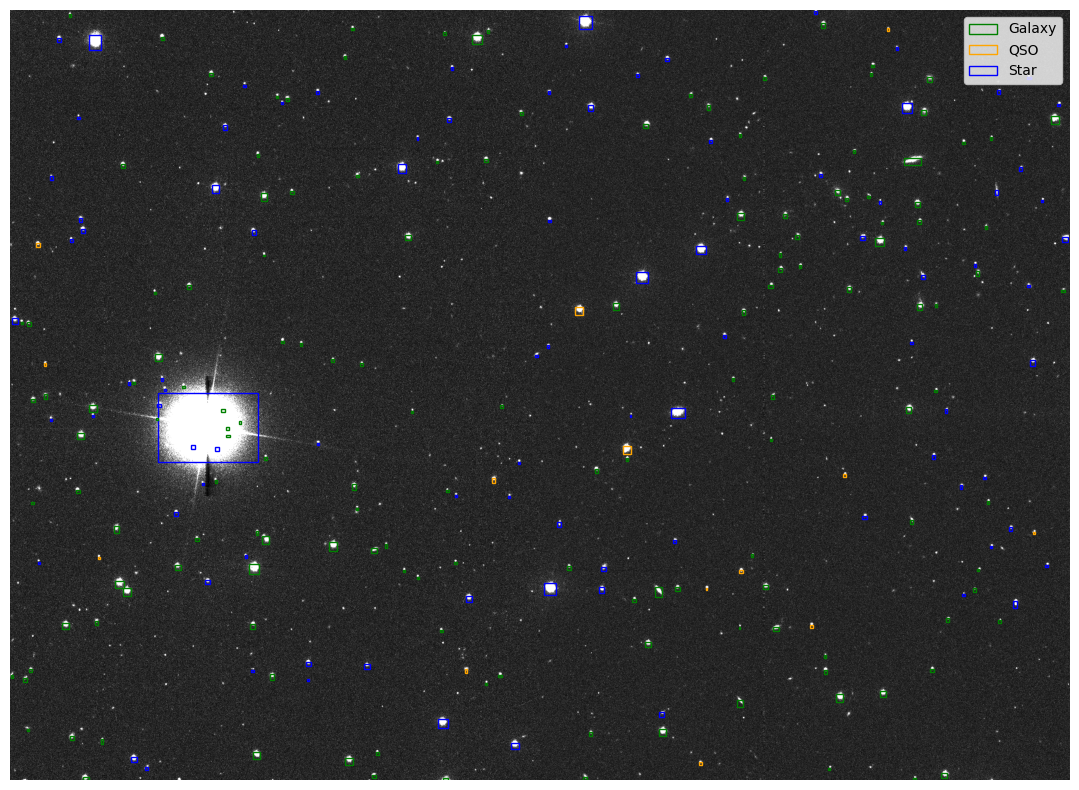

In [290]:
# plot the boxes again
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,10)


ax.imshow(img_data_buffer[best_band_idx], cmap="gray")
ax.axis("off")

for idx, bbox in enumerate(sources.bbox):
  obj_class = np.argmax(object_probas[idx])

  if obj_class == 0: # galaxy
    color = 'green'
    label = "Galaxy"
  elif obj_class == 1: # QSO
    color = 'orange'
    label = "QSO"
  elif obj_class == 2: # star
    color = 'blue'
    label = "Star"
  else:
    color = 'red'
    label = "Unknown"


  rect = patches.Rectangle(xy=(bbox.ixmin, bbox.iymin), width=(bbox.ixmax - bbox.ixmin), height=(bbox.iymax - bbox.iymin), edgecolor=color, fill=False)
  ax.add_patch(rect)


legend_elements = [
    patches.Rectangle(xy=[0,0], width=1, height=1,color='green', label="Galaxy", fill=False),
    patches.Rectangle(xy=[0,0], width=1, height=1,color='orange', label="QSO", fill=False),
    patches.Rectangle(xy=[0,0], width=1, height=1,color='blue', label='Star', fill=False),
]
ax.legend(handles = legend_elements, loc='upper right')

In [291]:
all_frame_sources[2,:,:,4].max()

1.0